In [1]:
import rasterio
import numpy as np
from e582lib.map_slices import get_basemap,make_basemap_xy
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import Normalize
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

### read in the tif file and get out the bands, including ndvi

use get_basemap to get basemap_args and x,y values for the map

In [2]:
#
# in_tif file written by the merge_modis notebook
#
in_tif = 'stretched_out.tif'
band_dict=dict()
with rasterio.open(in_tif,'r') as src:
    plot_dict=dict(src.profile)
    chancount=plot_dict['count']
    for channel in range(chancount):    
        tag_dict=dict(src.tags(channel+1))
        band_dict[tag_dict['name']]=src.read(channel+1)
width=plot_dict['width']
height=plot_dict['height']
crs = dict(plot_dict['crs'])
transform = plot_dict['transform']
basemap_args, xvals, yvals = get_basemap(width,height,crs,transform)
ndvi = band_dict['ndvi']
ndvi_masked=np.ma.masked_invalid(ndvi)


### set the ndvi palette

In [3]:
cmap=sns.diverging_palette(261, 153,sep=6, s=95, l=76,as_cmap=True)
vmin= -0.9
vmax=  0.9
cmap.set_over('r')
cmap.set_under('k',alpha=0.8)
cmap.set_bad('w',alpha=0.1)
the_norm=Normalize(vmin=vmin,vmax=vmax,clip=False)

### make the plot

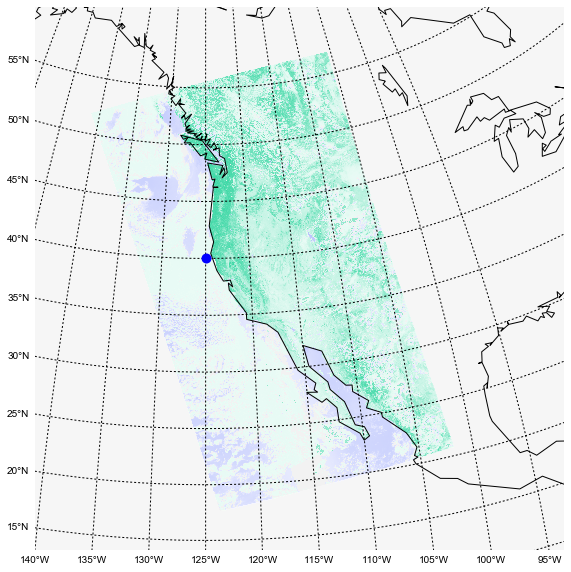

In [4]:
%matplotlib inline
fig, ax = plt.subplots(1,1,figsize=(10,10))
basemap_args['ax']=ax
bmap=Basemap(**basemap_args)

bmap.pcolormesh(xvals,yvals,ndvi_masked,cmap=cmap,norm=the_norm)
bmap.drawcoastlines()
lat_sep,lon_sep= 5, 5
parallels = np.arange(10, 60, lat_sep)
meridians = np.arange(-150,-90, lon_sep)
bmap.drawparallels(parallels, labels=[1, 0, 0, 0],
                        fontsize=10, latmax=90)
bmap.drawmeridians(meridians, labels=[0, 0, 0, 1],
                       fontsize=10, latmax=90);
x0,y0=bmap(crs['lon_0'],crs['lat_0'])
bmap.plot(x0,y0,'bo',markersize=10);

### now convert this to a rgb tif

In [5]:
def make_bytes(channel):
    """
    convert floating point into 8 bit ints
    
    Parameters
    ----------
    
    channel: ndarray of floats
    
    Returns
    -------
    
    int_chan: same data converted to uint8
    """
    hit = np.isnan(channel)
    channel[hit]=0
    hit=channel < 0
    channel[hit]=0
    maxval = np.amax(channel)
    norm_chan = channel/maxval
    norm_chan = norm_chan*255.
    int_chan = np.floor(norm_chan).astype(np.uint8)
    return int_chan

byte_dict = dict()
for key in ['1','3','4']:
    byte_dict[key] = make_bytes(band_dict[key])


In [6]:
tif_filename='rgb.tif'
data_type=byte_dict['1'].dtype
fill_value = np.array([0]).astype(np.int8)[0]
keys=['1','4','3']
numchans=len(keys)
comments='tif file written by plot_tiff.ipynb'
with rasterio.open(tif_filename,'w',driver='GTiff',
                   height=height,width=width,
                   count=numchans,dtype=data_type,
                   crs=crs,transform=transform,nodata= fill_value) as dst:
    for index,chan_name in enumerate(keys):
        dst.write(byte_dict[chan_name],index+1)
        dst.update_tags(index+1,name=key)
    dst.update_tags(comments=comments)

## define some functions to stretch images

#### Step 1: define a contrast stretch that takes the reflectance range minval to maxval and maps it to 0-255

In [7]:
def contrast_stretch(minval,maxval):
    """
    Parameters
    ----------
    
    minval: float
       number between 0 and 1 lower bound of stretch
    maxval: float
       number between 0 and 1 upper bound of stretch
    """
    left,right = [(minval,maxval),(0,255)]
    first_stretch=(right[1] - right[0])/(left[1] - left[0])
    return first_stretch

#### Step 2: define a non-linear stretch that gives the most colors to the darkest pixels

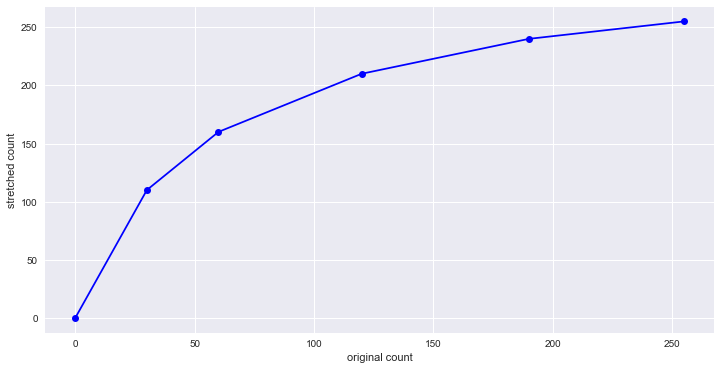

In [8]:
#make five intervals with a different stretch in each interval
stretch=[(0,0),(30,110),(60,160),(120,210),(190,240),(255,255)]
edges=[item[0] for item in stretch]
orig = [item[0] for item in stretch]
%matplotlib inline
stretched = [item[1] for item in stretch]
fig,ax=plt.subplots(1,1,figsize=(12,6))
ax.plot(orig,stretched,'bo-')
ax.set(xlabel='original count',ylabel='stretched count');

In [9]:
stretch_dict={}
for index in np.arange(1,len(stretch)):
    x1,y1=stretch[index]
    x0,y0=stretch[index-1]
    slope=(y1 - y0)/(x1 - x0)
    stretch_dict[index]=(x0,y0,slope)

In [10]:
stretch_zero = contrast_stretch(0,0.6)
bin_dict=dict()
stretched_dict=dict()
for channame in ['1','4','3']:
    the_chan=band_dict[channame]
    print('working on channel {}'.format(channame))
    rows,cols = the_chan.shape
    #
    # stretch to a maximum of 0.6
    #
    int_vals=np.floor(the_chan*stretch_zero)
    hit = int_vals < 0
    int_vals[hit]=0
    hit = int_vals > 255
    int_vals[hit]=255
    the_chan=int_vals.astype(np.int32)
    #
    # now apply the five separate stretches.  Remember that
    # searchsorted assigns bin 0 to values below the minimum (0)
    # and bin 6 to values above the maximum (255)
    # 
    #
    bin_dict[channame]=np.searchsorted(edges,the_chan.ravel())
    print('bins used: ',np.unique(bin_dict[channame]))
    chan_flat=the_chan.ravel()
    for index,binnum in enumerate(bin_dict[channame][:]):
        if binnum == len(edges):
            chan_flat[index]=255
        elif binnum == 0:
            continue
        else:
            #
            # apply a separate stretch to the pixels
            # in each of the five bins
            #
            x0,y0,slope = stretch_dict[binnum]
            y= (chan_flat[index] - x0)*slope + y0
            old_val=chan_flat[index]
            chan_flat[index]=y
    #
    # turn the flat channel arrays back into rows,cols
    #
    the_chan=chan_flat.reshape(rows,cols)
    #
    # turn the floating point numbers into bytes between 0-255
    #
    the_chan[...]=np.floor(the_chan)
    the_chan=the_chan.astype(np.int32)
    hit = the_chan > 255
    the_chan[hit]=255
    #
    # now all numbers fit into a byte
    #
    stretched_dict[channame]=the_chan.astype(np.uint8)
    avg=np.nanmean(the_chan.ravel())
    print('stretched mean for {} is {}'.format(channame,avg))
#


working on channel 1
bins used:  [0 1 2 3 4 5]
stretched mean for 1 is 58.94378746666667
working on channel 4
bins used:  [0 1 2 3 4 5]
stretched mean for 4 is 61.17789
working on channel 3
bins used:  [0 1 2 3 4 5]
stretched mean for 3 is 65.63464933333333


In [11]:
chan_list=['1','4','3']
height,width = stretched_dict[chan_list[0]].shape
num_chans=len(chan_list)
fill_value=0
data_type=stretched_dict[chan_list[0]].dtype
comments='written by plot_tiff'
tif_filename='stretched_rgb.tif'

with rasterio.open(tif_filename,'w',driver='GTiff',
                   height=height,width=width,
                   count=num_chans,dtype=data_type,
                   crs=crs,transform=transform,nodata= fill_value) as dst:
    for index,chan_name in enumerate(chan_list):
        result=stretched_dict[chan_list[index]][...]
        dst.write(result,index+1)
        dst.update_tags(index+1,name=chan_list[index])
    dst.update_tags(comments=comments)